# 00_preprocess.ipynb
### Preprocess Gridded Data to find Anomalies and Extreme Values

This notebook provides an example of how one might preprocess gridded sea surface temperature (SST) data to extract anomalies and detect extreme values. Here we will use monthly mean SST from the [NOAA Optimum Interpolation Sea Surface Temperature](https://www.ncdc.noaa.gov/oisst/data-access) (OISST v2.1) dataset. This data is measured from a blend of satellite and in-situ observations. We elect to use data from AVHRR-only satellites. This product is available from September 1981 through present on a 1/4º global regular grid.

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 1. Import data
- load the daily OISST dataset and resample to monthly means
- load the landmask 

In [ ]:
# Import daily OISST
path = '/glade/scratch/scanh/OISST/v2.1/'
ds = xr.open_mfdataset(path+'oisst-avhrr-v02r01.*.nc', decode_times=True, combine='by_coords')

# Calculate monthly mean SST
mnsst = ds.sst.squeeze().resample(time='MS').mean().squeeze()
mnsst.load();

In [ ]:
# import land mask
dm = xr.open_dataset(path+'lsmask.oisst.v2.nc', decode_times=True)
# reproject = np.flipud(dm.mask[0, :,:].transpose('lat', 'lon'))
# land_mask = xr.DataArray(reproject, dims=['lat','lon'], coords={'lat':dm.lat, 'lon':dm.lon})  
land_mask = dm.lsmask[0,:,:]

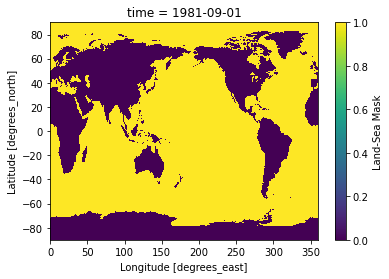

In [ ]:
dm.lsmask[0,:,:].plot()

In [ ]:
years = pd.DatetimeIndex(mnsst.time.values).year
months = pd.DatetimeIndex(mnsst.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

### 2. Fit mean, trend, annual, and semi-annual harmonics to SST over entire record¶


In [ ]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':mnsst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':mnsst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(mnsst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  

# Construction of the mean, trend, and seasonal cycle
mean = xr.DataArray(model_da[:,0].dot(sst_mod[0,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})   
trend = xr.DataArray(model_da[:,1].dot(sst_mod[1,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})    
seas = xr.DataArray(model_da[:,2:].dot(sst_mod[2:,:,:]), dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})

### 3. Compute SST anomalies (SSTa) and detrend

In [ ]:
# redefine SST with and without the trend
sst_notrend = xr.DataArray((mnsst-trend).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  
sst_trend = xr.DataArray(mnsst.values, dims=['time','lat','lon'], coords={'time': mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})  

# compute anomalies (SSTa) by removing model coefficients – with and without the trend
ssta_notrend = xr.DataArray((mnsst.values-model_da.dot(sst_mod)).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 
ssta_trend = xr.DataArray((mnsst.values-model_da.dot(sst_mod[[0,2,3,4,5],:,:])).values, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values})

### 4. Standardized SSTa by dividing by the monthly standard deviation
This step places equal variance on SSTa at all spatial points

In [ ]:
# compute monthly standard deviation
stdev_notrend = ssta_notrend.groupby(ssta_notrend.time.dt.month).std()
stdev_trend = ssta_trend.groupby(ssta_trend.time.dt.month).std()

# Initalize xarray DataArray for SSTa with and without trend
ssta_stn_notrend = np.empty((ssta_notrend.shape[0], ssta_notrend.shape[1], ssta_notrend.shape[2])) 
ssta_stn_notrend[:] = np.nan
ssta_stn_notrend = xr.DataArray(ssta_stn_notrend, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 

ssta_stn_trend = np.empty((ssta_trend.shape[0], ssta_trend.shape[1], ssta_trend.shape[2])) 
ssta_stn_trend[:] = np.nan
ssta_stn_trend = xr.DataArray(ssta_stn_trend, dims=['time','lat','lon'], coords={'time':mnsst.time, 'lat':mnsst.lat.values, 'lon':mnsst.lon.values}) 

# Loop over months and divde by standard deviation
for i in np.arange(1,13):
    I = np.where(mnsst.time.dt.month==i)[0]
    ssta_stn_notrend[I,:,:] = ssta_notrend[I,:,:]/stdev_notrend[i-1,:,:]
    ssta_stn_trend[I,:,:] = ssta_trend[I,:,:]/stdev_trend[i-1,:,:]

### 5. Define a threshold to define extreme values
Here we will use the 90th percentile relative to the monthly values over the entire record

In [ ]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Compute values of the monthly threshold
prct_notrend = ssta_stn_notrend.quantile(thresh, dim='time', keep_attrs=True, skipna=True)
prct_trend = ssta_stn_trend.quantile(thresh, dim='time', keep_attrs=True, skipna=True)

In [ ]:
# Compute SSTa relative to the threshold defined above in Step 5. 
ssta_prc_notrend = ssta_stn_notrend - prct_notrend
ssta_prc_trend = ssta_stn_trend - prct_trend

In [ ]:
# # Intialize xarray DataArrays for SSTa relative to the threshold defined above in Step 5.
# ssta_prc_notrend = np.empty((ssta_stn_notrend.shape[0], ssta_stn_notrend.shape[1], ssta_stn_notrend.shape[2])) 
# ssta_prc_notrend[:] = np.nan
# ssta_prc_notrend = xr.DataArray(ssta_prc_notrend,
#                                 dims=('time', 'lat', 'lon'),
#                                 coords={'time': ssta_stn_notrend.time.values,
#                                         'lat': ssta_stn_notrend.lat.values,
#                                         'lon': ssta_stn_notrend.lon.values,
#                                         'quantile':thresh}) 

# ssta_prc_trend = np.empty((ssta_stn_trend.shape[0], ssta_stn_trend.shape[1], ssta_stn_trend.shape[2])) 
# ssta_prc_trend[:] = np.nan
# ssta_prc_trend = xr.DataArray(ssta_prc_trend,
#                               dims=('time', 'lat', 'lon'),
#                               coords={'time': ssta_stn_trend.time.values,
#                                       'lat': ssta_stn_trend.lat.values,
#                                       'lon': ssta_stn_trend.lon.values,
#                                       'quantile':thresh})

In [ ]:
# # Loop over months and compute SSTa relative to the threshold defined above in Step 5.  
# for i in np.arange(1,13,1):
#     I = np.where(mnsst.time.dt.month==i)[0]
#     ssta_prc_notrend[I,:,:] = ssta_stn_notrend[I,:,:]-prct_notrend[i-1,:,:] 
#     ssta_prc_trend[I,:,:] = ssta_stn_trend[I,:,:]-prct_trend[i-1,:,:]

### Visualize the data by plotting maps of the (a) climatology, (b) standard deviation, (c) seasonal amplitude, and (d) trend. 

In [ ]:
import os, sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

cptpath = r'/glade/u/home/scanh/getcpt-master'
sys.path.append(cptpath)
import get_cpt 

##################################################
# Compute the standard deviation of detrended SSTA anomalies
stdev_global = ssta_notrend.std('time')
stdev_global.load()

# Here, we are only interested in the data between 70ºS and 65ºN
stdev_global = stdev_global.sel(lat=slice(-70,65))
mean_sst = mean[0,:,:].sel(lat=slice(-70,65))

# Next, we will calculate the seasonal cycle amplitude
S = seas+mean
seas_amp = S.max('time') - S.min('time')
# again only selecting data betwen 70ºS and 65ºN
seas_amp = seas_amp.sel(lat=slice(-70,65))

# The trend is calculated 1982-2012 or 1989-2019
T = trend+mean
T = T.sel(time=slice('1990-01-01','2020-12-01'))
T = T.sel(lat=slice(-70,65))
trend_slope = T[-1,:,:]-T[0,:,:]

# Create a mask over the poles
blobs_masked = ssta_notrend.where((ssta_notrend.lat < 65) & (ssta_notrend.lat > -70), drop=False, other=9999)
mask = blobs_masked.where(blobs_masked == 9999, other=np.nan, drop=False)

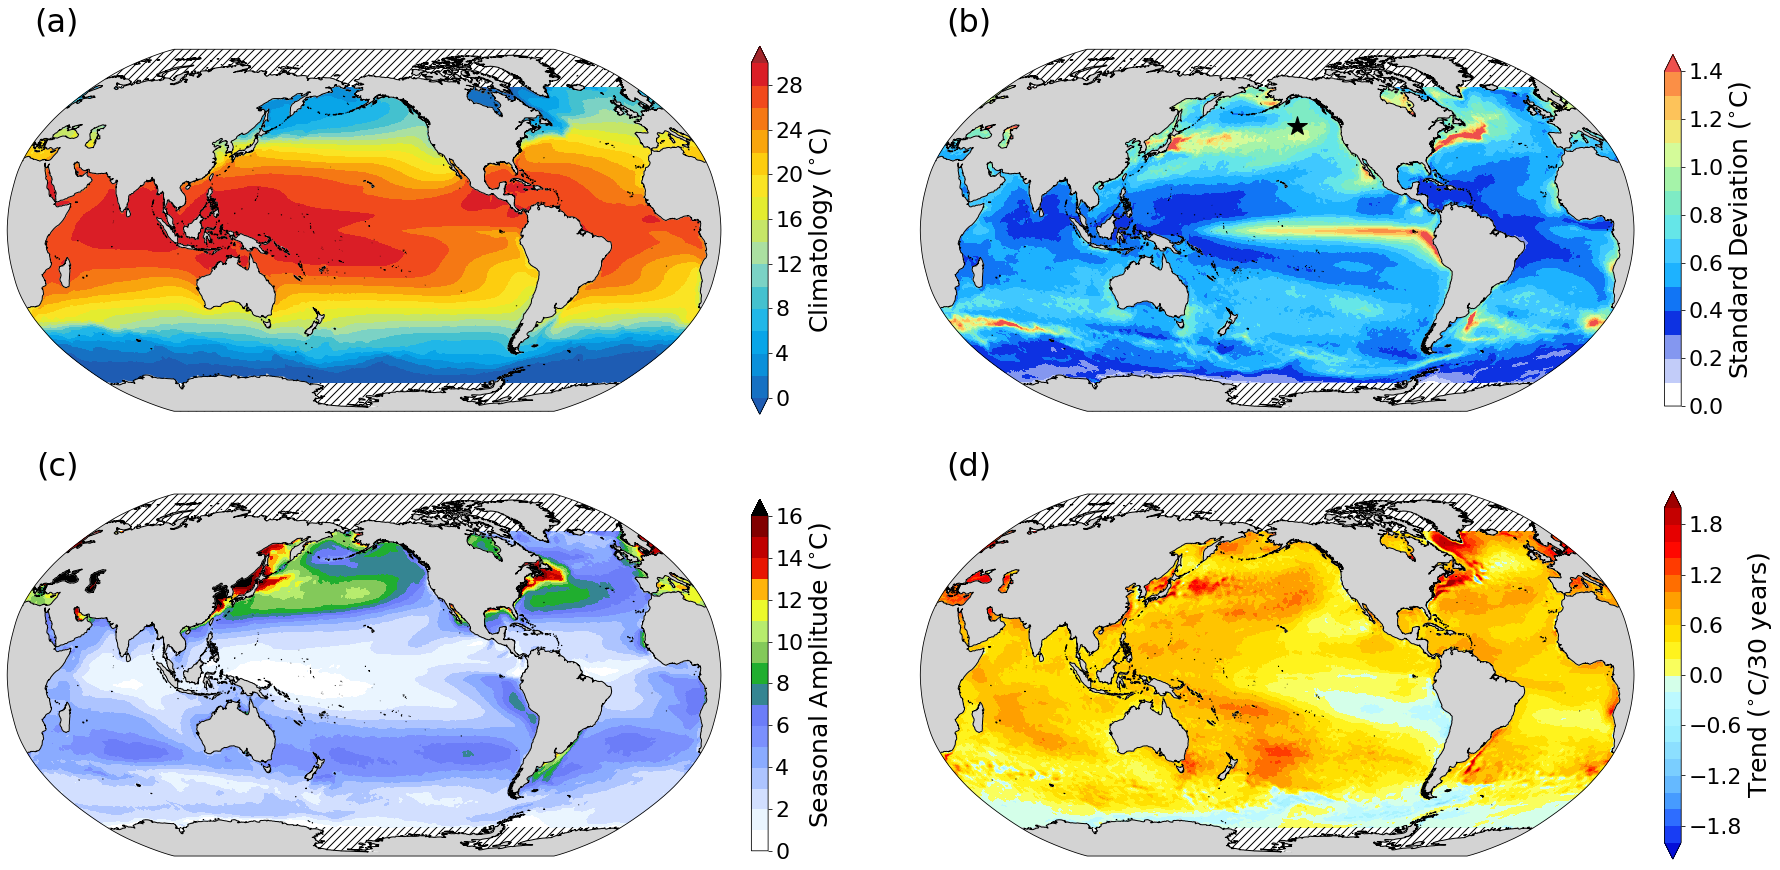

In [ ]:
## Make figure 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(30,15)) 

lon=211.125 
lat=46.625 

# (a) Climatology
ax = plt.subplot(221, projection=ccrs.Robinson(central_longitude=200))
# plt.gca().patch.set_color('.30')
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = mean_sst.plot.pcolormesh(vmin=0, vmax=30, levels=np.arange(0,32,2),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/temperature.cpt'), extend='both',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Climatology ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(a)', size=32, horizontalalignment='right', transform=ax.transAxes)


# (b) Standard Deviation
ax = plt.subplot(222, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = stdev_global[:,:].plot.pcolormesh(vmin=0, vmax=1.4, levels=np.arange(0,1.5,.1),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/seminf-haxby.cpt'), extend='max',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Standard Deviation ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.plot(lon,lat,'k*',ms=20,transform=ccrs.PlateCarree())
plt.text(0.1,1.05, '(b)', size=32, horizontalalignment='right', transform=ax.transAxes)

# (c) Seasonal Amplitude
ax = plt.subplot(223, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = seas_amp.plot.pcolormesh(vmin=0, vmax=20, levels=np.arange(0,17,1),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/precip2_17lev.cpt'), extend='max',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Seasonal Amplitude ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(c)', size=32, horizontalalignment='right', transform=ax.transAxes)

# (d) Trend
ax = plt.subplot(224, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = trend_slope.plot.pcolormesh(vmin=-2, vmax=2, levels=np.arange(-2,2.2,.2),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/GMT_panoply.cpt'), extend='both',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Trend ($\rm^{\circ}C/30$ years)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(d)', size=32, horizontalalignment='right', transform=ax.transAxes);


# fig.savefig('/glade/u/home/scanh/figures/ocetrac_figures/Figure1_oisst_v02r01.png', bbox_inches='tight', format='png', dpi=300)


### 6. Find where the standardized SSTa exceeds the threshold

In [ ]:
# Take only the SSTa that exceeds the calculated monthly threshold
mhw_ssta_notrend = ssta_stn_notrend.where(ssta_prc_notrend>0.)
mhw_ssta_trend = ssta_stn_trend.where(ssta_prc_trend>0.)

### Visualize anomaly detection

In [ ]:
lon=211.125 
lat=46.625 
point_seas = seas.loc[dict(lon=lon, lat=lat)]
point_mean = mean.loc[dict(lon=lon, lat=lat)]
point_trend = trend.loc[dict(lon=lon, lat=lat)]

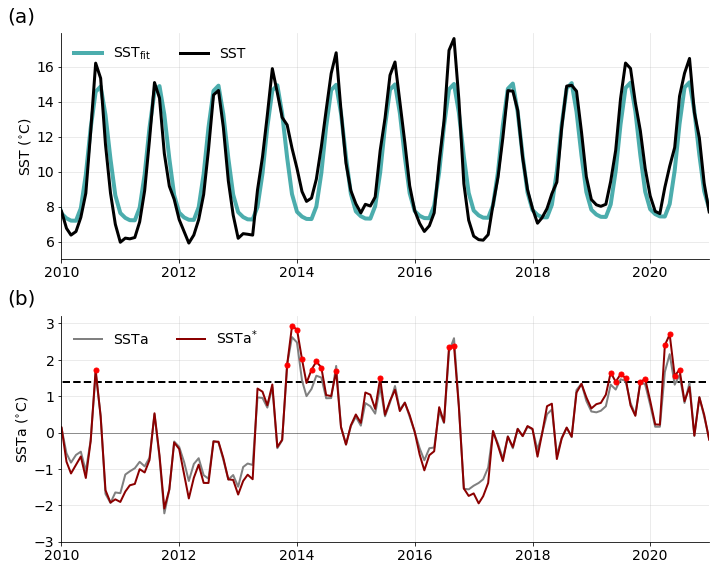

In [ ]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
fig = plt.figure(figsize=(10,8)) 

ax = plt.subplot(211)
plt.text(-0.04,1.05, '(a)', size=20, horizontalalignment='right', transform=ax.transAxes);
s = plt.plot(point_seas.time, point_seas+point_mean+point_trend, color='darkcyan', lw=4, alpha=0.7, label=r"$\rmSST_{fit}$")
plt.plot(mnsst.time, mnsst.loc[dict(lon=lon, lat=lat)], color='black', lw=3, label='SST')
plt.xlim('2010-01-01',point_seas.time[-1].values);
plt.ylim(5,17.9)
plt.ylabel(r"SST ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)

ax = plt.subplot(212)
plt.text(-0.04,1.05, '(b)', size=20, horizontalalignment='right', transform=ax.transAxes);
plt.plot(ssta_stn_notrend.time, np.zeros(len(ssta_stn_notrend.time)), color='k', lw=1, alpha=0.4)
plt.plot(ssta_stn_notrend.time, np.ones(len(ssta_stn_notrend.time))*prct_notrend.loc[dict(lon=lon, lat=lat)].values, '--', color='k', lw=2)
plt.plot(ssta_notrend.time, ssta_notrend.loc[dict(lon=lon, lat=lat)], color='gray', lw=2, label=r"$\rmSSTa$")
plt.plot(ssta_stn_notrend.time, ssta_stn_notrend.loc[dict(lon=lon, lat=lat)], color='darkred', lw=2, label=r"$\rmSSTa^{*}$")
plt.plot(mhw_ssta_notrend.time, mhw_ssta_notrend.loc[dict(lon=lon, lat=lat)],'r.', ms=10)
plt.xlim('2010-01-01',point_seas.time[-1].values);
# plt.ylim(5,17.9)
plt.ylabel(r"$\rmSSTa$ ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()


### 7. Save the extreme values of SSTa relative to the mean in netCDF format
! Need to add land mask to output

In [ ]:
# Specify path to save output 
save_to = '/glade/scratch/scanh/MHW_pre/'

# Convert xarray DatAarray to Dataset
mhw_ssta_notrend.compute()
mhw_ssta_notrend_ds = mhw_ssta_notrend.to_dataset(name='mhw_ssta_notrend')
mhw_ssta_notrend_ds['mask'] = dm.lsmask[0,:,:]
mhw_ssta_notrend_ds.attrs['threshold'] = 0.9

mhw_ssta_trend.compute()
mhw_ssta_trend_ds = mhw_ssta_trend.to_dataset(name='mhw_ssta_trend')
mhw_ssta_trend_ds['mask'] = dm.lsmask[0,:,:]
mhw_ssta_trend_ds.attrs['threshold'] = 0.9


In [ ]:
# Save Dataset to netCDF
mhw_ssta_notrend_ds.to_netcdf(save_to+'preprocess_mhw_OISSTv2_monthly_notrend_stn.nc', mode='w')

mhw_ssta_trend_ds.to_netcdf(save_to+'preprocess_mhw_OISSTv2_monthly_trend_stn.nc', mode='w')


In [ ]:
mhw_ssta_notrend_ds

NameError: name 'mhw_ssta_notrend_ds' is not defined